In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = data[data.Y != 90]
#data = data[data.Resolution != 'NONE']
#stk_list = ['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT']
#data = data[data.Category.isin(stk_list)]
#test = test[data.PdDistrict == 'MISSION']
data['Dates'] = pd.to_datetime(data['Dates'])
data['Year'] = data.Dates.dt.year
data['Month'] = data.Dates.dt.month
data['Day'] = data.Dates.dt.day
data['Date'] = data.Dates.dt.date
data['Hour'] = data.Dates.dt.hour
data['DayOfYear'] = data.Dates.dt.dayofyear
data['WeekDay'] = data.Dates.dt.weekday
#
test['Dates'] = pd.to_datetime(test['Dates'])
test['Year'] = test.Dates.dt.year
test['Month'] = test.Dates.dt.month
test['Day'] = test.Dates.dt.day
test['Date'] = test.Dates.dt.date
test['Hour'] = test.Dates.dt.hour
test['DayOfYear'] = test.Dates.dt.dayofyear
test['WeekDay'] = test.Dates.dt.weekday


In [3]:
data['PdCode'] = data['PdDistrict'].replace('SOUTHERN',1)
data['PdCode'] = data['PdCode'].replace('MISSION',2)
data['PdCode'] = data['PdCode'].replace('NORTHERN',3)
data['PdCode'] = data['PdCode'].replace('BAYVIEW',4)
data['PdCode'] = data['PdCode'].replace('CENTRAL',5)
data['PdCode'] = data['PdCode'].replace('TENDERLOIN',6)
data['PdCode'] = data['PdCode'].replace('INGLESIDE',7)
data['PdCode'] = data['PdCode'].replace('TARAVAL',8)
data['PdCode'] = data['PdCode'].replace('PARK',9)
data['PdCode'] = data['PdCode'].replace('RICHMOND',10)
test['PdCode'] = test['PdDistrict'].replace('SOUTHERN',1)
test['PdCode'] = test['PdCode'].replace('MISSION',2)
test['PdCode'] = test['PdCode'].replace('NORTHERN',3)
test['PdCode'] = test['PdCode'].replace('BAYVIEW',4)
test['PdCode'] = test['PdCode'].replace('CENTRAL',5)
test['PdCode'] = test['PdCode'].replace('TENDERLOIN',6)
test['PdCode'] = test['PdCode'].replace('INGLESIDE',7)
test['PdCode'] = test['PdCode'].replace('TARAVAL',8)
test['PdCode'] = test['PdCode'].replace('PARK',9)
test['PdCode'] = test['PdCode'].replace('RICHMOND',10)

In [4]:
# Big Picture of Data
print "Train Data:"
print data.shape
print data.columns.values
print "Test Data:"
print test.shape
print test.columns.values


Train Data:
(877982, 17)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y' 'Year' 'Month' 'Day' 'Date' 'Hour' 'DayOfYear' 'WeekDay'
 'PdCode']
Test Data:
(884262, 15)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y' 'Year' 'Month'
 'Day' 'Date' 'Hour' 'DayOfYear' 'WeekDay' 'PdCode']


In [4]:
# Add a column counting days since the min date in the dataset
def add_date_diff(df):
    datetime_vector = pd.to_datetime(df['Dates'])
    date_vector = datetime_vector.dt.date
    date_diff_vector = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    df['DateDiff'] = date_diff_vector

add_date_diff(data)
add_date_diff(test)
print data.DateDiff.describe()
print test.DateDiff.describe()


count    877982.000000
mean       2260.896718
std        1325.321142
min           0.000000
25%        1101.000000
50%        2252.000000
75%        3444.000000
max        4510.000000
Name: DateDiff, dtype: float64
count    884262.000000
mean       2259.105934
std        1327.543529
min           0.000000
25%        1088.000000
50%        2250.000000
75%        3444.000000
max        4512.000000
Name: DateDiff, dtype: float64


In [5]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
np.random.seed(100)

rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

dev = data.ix[rows]
train = data.drop(rows)

print train.shape
print dev.shape
print test.shape


(790184, 18)
(87798, 18)
(884262, 16)


In [6]:
# Convert to Numpy Format
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
#a + (x-A)*(b-a)/(B-A) 
train_normed = 0 + (np.abs(train_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
dev_normed = 0 + (np.abs(dev_data) - np.abs(dev_data).min(axis=0))*(1-0)/(np.abs(dev_data).max(axis=0) - np.abs(dev_data).min(axis=0)) 
test_normed = 0 + (np.abs(test_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
full_normed = 0 + (np.abs(full_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 

print train_normed.min(axis=0)
print train_normed.max(axis=0)

[ 0.  0.  0.]
[ 1.  1.  1.]


{'C': 0.001}


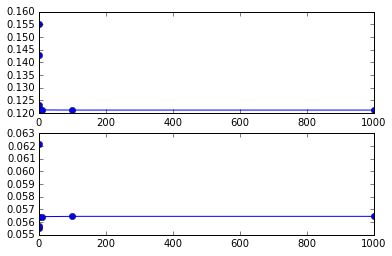

In [9]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf.fit(train_data, train_labels)
print clf.best_params_
#print clf.grid_scores_
res = zip(*[(f1m, f1s.std(), p['C']) 
            for p, f1m, f1s in clf.grid_scores_])
plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.001)
model.fit(train_normed, train_labels)
test_predict = np.array(model.predict_proba(test_normed))
#results = create_submission(test_predict)

In [23]:
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(train_normed, train_labels)
test_predict2 = KNNmodel.predict_proba(test_normed).astype(int)

In [22]:
test_predict2

array(['VANDALISM', 'ASSAULT', 'LARCENY/THEFT', ..., 'ROBBERY',
       'NON-CRIMINAL', 'LARCENY/THEFT'], dtype=object)

In [25]:
results = create_submission(np.maximum(test_predict,test_predict2))

In [16]:
def create_submission(preds):
    labels = ["Id",
                "ARSON",
                "ASSAULT",
                "BAD CHECKS",
                "BRIBERY",
                "BURGLARY",
                "DISORDERLY CONDUCT",
                "DRIVING UNDER THE INFLUENCE",
                "DRUG/NARCOTIC",
                "DRUNKENNESS",
                "EMBEZZLEMENT",
                "EXTORTION",
                "FAMILY OFFENSES",
                "FORGERY/COUNTERFEITING",
                "FRAUD",
                "GAMBLING",
                "KIDNAPPING",
                "LARCENY/THEFT",
                "LIQUOR LAWS",
                "LOITERING",
                "MISSING PERSON",
                "NON-CRIMINAL",
                "OTHER OFFENSES",
                "PORNOGRAPHY/OBSCENE MAT",
                "PROSTITUTION",
                "RECOVERED VEHICLE",
                "ROBBERY",
                "RUNAWAY",
                "SECONDARY CODES",
                "SEX OFFENSES FORCIBLE",
                "SEX OFFENSES NON FORCIBLE",
                "STOLEN PROPERTY",
                "SUICIDE",
                "SUSPICIOUS OCC",
                "TREA",
                "TRESPASS",
                "VANDALISM",
                "VEHICLE THEFT",
                "WARRANTS",
                "WEAPON LAWS"
              ]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    # Write results to csv
    np.savetxt('sample.csv', results, fmt='%f', delimiter=',', header=head_str, comments='')

    return results

In [176]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(full_normed, full_labels)
dev_predict = KNNmodel.predict_proba(test_normed).astype(int)

In [179]:
results = create_submission(dev_predict)

In [181]:
print results

[[     0      0      1      0      0]
 [     1      1      0      0      0]
 [     2      0      1      0      0]
 ..., 
 [884259      1      0      0      0]
 [884260      0      0      1      0]
 [884261      0      1      0      0]]


In [135]:
KNNmodel

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')